In [ ]:
import io
import os
import re
import sys
import csv
import gzip
import time
import json
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
from scipy.stats import pearsonr
# import sqlite3
# from PIL import Image
import matplotlib.pyplot as plt
# from plotnine import *
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
# from collections import Counter
# import seaborn as sns
# import matplotlib.colors as mcolors
# from matplotlib.ticker import FuncFormatter
import itertools
import collections
import pyreadr
# import patchworklib as pw
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus
from lcwgsus.variables import *
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.options.mode.chained_assignment = None

# Genuine logics changed from the main script were marked by string **X** in the original R files.
# Simplicity changes were marked by string **Y**

In [2]:
gene = 'DRB1'
region = 'DRB1'
nucleotides = ['A', 'T', 'C', 'G']
ipd_gen_file = '/Users/sus_zhang/Desktop/Suuuuuuuus/misc_data/alignments/' + gene + '_gen.txt'
if not os.path.exists(ipd_gen_file):
    ipd_gen_file = '/well/band/users/rbx225/recyclable_files/hla/alignments/' + gene + '_gen.txt'

hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hlagenes.txt', sep = ' ')

In [3]:
with open(ipd_gen_file, "r") as file:
    lines = file.readlines()
gDNA_idx = []
names = []
i = 0
while len(gDNA_idx) < 2:
    l = lines[i]
    if 'gDNA' in l:
        gDNA_idx.append(i)
    elif l.lstrip(' ').split(' ')[0].startswith(gene + '*'):
        name = l.lstrip(' ').split(' ')[0]
        names.append(name)
    i += 1
    
first_base = int(lines[gDNA_idx[0]].split(' ')[-1].split('\n')[0])
n_alleles = gDNA_idx[1] - gDNA_idx[0] - 3

alleles_dict = {k:'' for k in names}
for i, s in enumerate(lines):
    r = s.lstrip(' ')
    if r.startswith(gene):
        r = r.rstrip(' \n')
        name = r.split(' ')[0]
        sequence = r.split(' ')[2:]
        sequence = ''.join(sequence)
        alleles_dict[name] = alleles_dict[name] + sequence
    
df = pd.DataFrame({key: list(value) for key, value in alleles_dict.items()}).T
df = df.drop(columns=df.columns[df.eq('|').all()])
df.columns = range(df.shape[1])

length = len(df.columns)
positions = [first_base]*length

df.loc[len(df)] = positions

r_idx = len(df) - 1
for i in df.columns[1:]:
    if df.iloc[0, i] == '.':
        df.iloc[r_idx, i] = df.iloc[r_idx, i-1]
    else:
        if df.iloc[r_idx, i-1] != -1:
            df.iloc[r_idx, i] = df.iloc[r_idx, i-1] + 1
        else:
            df.iloc[r_idx, i] = df.iloc[r_idx, i-1] + 2 # No zero in position. ATG is encoded by 1.
df.columns = df.iloc[r_idx]
df = df.iloc[:r_idx]

In [3]:
original_refdir = '/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/QUILT_ref_files/'
auxiliary_dir = '/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/' 
all_haplotypes = pyreadr.read_r(original_refdir + 'quilt.hrc.hla.all.haplotypes.RData') # See if it is possible to remove the 32 bases dependency
snpformatalleles = pyreadr.read_r(original_refdir + 'hlaDRB1snpformatalleles.RData')
fullallelesfilledin = pyreadr.read_r(original_refdir + 'HLADRB1fullallelesfilledin.RData')
full = pyreadr.read_r(original_refdir + 'hlaDRB1full.RData')

hlatypes = pd.read_csv(auxiliary_dir + '20181129_HLA_types_full_1000_Genomes_Project_panel.txt', sep = '\t')
ref_samples = pd.read_csv(auxiliary_dir + 'oneKG.samples', sep = ' ')
ref_samples_removed = ref_samples[~ref_samples['SAMPLE'].isin(hlatypes['Sample ID'].tolist())]
samples_to_remove = ref_samples_removed['SAMPLE'].tolist()
reference_exclude_samplelist_file = ''

if reference_exclude_samplelist_file != '':
    samples_to_remove = samples_to_remove + lcwgsus.read_tsv_as_lst(reference_exclude_samplelist_file)
# if samples_to_remove is not none, save to "hlauntyped.exclude.txt"

hlatypes = hlatypes[~hlatypes['Sample ID'].isin(samples_to_remove)]
reference_samples = all_haplotypes['reference_samples']
hlatypes = hlatypes[hlatypes['Sample ID'].isin(reference_samples['SAMPLE'].tolist())].reset_index(drop = True).sort_values(by = 'Sample ID')

In [7]:
# oldsnpinfo -> prepared_vcf
# ss -> variant_alleles
# samples -> alleles
# qq -> positions
knownvarsfiltered = snpformatalleles['knownvarsfiltered'].copy()
resmat = snpformatalleles['resmat'].copy()
knownvarsfiltered = knownvarsfiltered[knownvarsfiltered[1].isin(nucleotides) & knownvarsfiltered[2].isin(nucleotides)].reset_index(drop = True)

ids = "chr6:" + knownvarsfiltered[0].astype(str)
prepared_vcf = pd.concat([ids, knownvarsfiltered], axis=1)
alleles = resmat.index
prepared_vcf.columns = ["id", "position", "a0", "a1"]
prepared_vcf['position']  = prepared_vcf['position'].astype(int)

ourpos = fullallelesfilledin['ourpos']['ourpos'].tolist()
fullalleles = fullallelesfilledin['fullalleles'].copy()

retained_index = []
variant_alleles = pd.DataFrame(index=fullalleles.index)

for i in range(len(prepared_vcf)):
    _, pos, ref, alt = prepared_vcf.iloc[i,:]
    index = np.where(ourpos == pos)[0]
    if index.size != 0:
        index = index[0]
        retained_index.append(index)
        variant_alleles[variant_alleles.shape[1]] = fullalleles[index].map({ref: '0', alt: '1'}).fillna(fullalleles[index])
    else:
        prepared_vcf.iloc[i,2] = 'tbr' # tbr: To be removed

prepared_vcf = prepared_vcf[prepared_vcf['a0'] != 'tbr'].reset_index(drop = True)
variant_alleles = variant_alleles.T

positions = prepared_vcf['position'].astype(float).values  # Convert position to double

zz = np.zeros(variant_alleles.shape[0]) 
for i in range(len(zz)):
    zz[i] = np.sum(ourpos == positions[i])
zz2 = np.zeros_like(zz)
zz2 = np.sum(~((variant_alleles == '0') | (variant_alleles == '1')), axis=1)
zz3 = np.zeros_like(zz)
for i in range(len(zz3)):
    zz3[i] = np.sum(positions == positions[i])
zz4 = np.sum(~((variant_alleles == '0') | (variant_alleles == '1') | (variant_alleles == ".")), axis=1)
filter_conditions = (zz3 == 1) & (zz == 1) & (zz2 < variant_alleles.shape[1] * 0.1) & (zz2 < 0.5 * np.sum(variant_alleles == '1', axis=1)) & (zz4 == 0)

# keep sites uniquely mapping, not overlapping another SNP, with at most 10% gaps and 2-fold more non-ancestral than gaps
snpinfo = prepared_vcf.loc[filter_conditions, :].reset_index(drop = True)
variant_alleles = variant_alleles.loc[filter_conditions, :]
variant_alleles[variant_alleles == "."] = 0 # indels set to 0
haps = variant_alleles.copy().reset_index(drop = True)
# haps is `n_variant \times n_alleles` df, with each entry as 0/1 representing ref/alt from the fake vcf "prepared_vcf"

In [6]:
samples = np.array(alleles).reshape(-1, 1)
c1 = [s[0].split('*') for s in samples]
vv = np.empty((samples.shape[0], 3), dtype=object)
ww = [c[1] for c in c1]
for i in range(len(c1)):
    vv[i, 0] = c1[i][0]
c1 = [w.split(':') for w in ww]
for i in range(len(c1)):
    vv[i, 1] = c1[i][0]
    vv[i, 2] = c1[i][1]
fourdigit = [f"{vv[i, 1]}:{vv[i, 2]}" for i in range(len(vv))]
ufourdigit = np.unique(fourdigit)
# Convert reference alleles to 4-digit resolution. vv and ww are just intermediate variables of no use
# ufourdigit is unique 4-digit alleles

haps = np.array(haps, dtype=float)
newhaps = np.empty((haps.shape[0], len(ufourdigit)))
for i in range(newhaps.shape[1]):
    tt = np.where(np.array(fourdigit) == ufourdigit[i])[0]
    if len(tt) < 2:
        tt = np.concatenate((tt, tt))
    newhaps[:, i] = np.mean(haps[:, tt], axis=1)
newhaps = pd.DataFrame(newhaps, columns = ufourdigit)
# newhaps is the result after averaging 4 digit resolution
    
# pos is from the QUILT_prepare_ref utility. It seems to record biallelic SNP variant information
pos = all_haplotypes['pos']

cols = snpinfo.columns.tolist()
full_vcf = pos.copy()[['POS', 'REF', 'ALT']]
full_vcf.columns = cols[1:]
same = pd.merge(full_vcf, snpinfo, on = cols[1:], how = 'inner')

snpinfo_flipped = snpinfo.iloc[:,[0, 1, 3, 2]]
snpinfo_flipped.columns = cols
flipped = pd.merge(full_vcf, snpinfo_flipped, on = cols[1:], how = 'inner')

merge = pd.concat([same, flipped]).sort_values(by = 'position', ascending = True)
locs = full_vcf.index[full_vcf['position'].isin(merge['position'].tolist())]

newhaps2 = newhaps.loc[newhaps.index.isin(snpinfo[snpinfo['position'].isin(same['position'])].index)]
if len(flipped) != 0:
    newhaps2_flipped = 1 - newhaps.loc[newhaps.index.isin(snpinfo[snpinfo['position'].isin(flipped['position'])].index)]
    newhaps2 = pd.concat([newhaps2, newhaps2_flipped])
newhaps2 = newhaps2.reset_index(drop = True)
# newhaps2 further filtered out variants that are not observed in the 'pos' dataframe
# This step really filters out a plethora of variants.. Is this really necessary? 
# Is it possible to circumvent that step such that we dont utilise any information from the `QUILT` output?

# Or it might be those variants are what we could observe from the BAM files, if so that makes sense then.

In [7]:
def translate(matchlist):
    qq = np.array(matchlist)
    signs = np.zeros(len(matchlist), dtype=int)
    
    signs[qq < 0] = 1
    qq[signs == 1] += 2**31
    
    res = np.zeros((len(matchlist), 0), dtype=float)
    
    for i in range(31):
        tempres = qq % 2
        qq = (qq - tempres) // 2
        res = np.hstack((res, tempres.reshape(-1, 1)))
    
    res = np.hstack((res, signs.reshape(-1, 1)))
    
    res[res == 1] = 0.999
    res[res == 0] = 0.001
    
    return res

In [8]:
# ourtypes -> reftypes
region_pattern = f"HLA.{region}."
cols = [i for i, col in enumerate(hlatypes.columns) if re.search(region_pattern, col)]

reftypes1 = hlatypes.iloc[:, cols[0]].astype(str).tolist()
reftypes1 = [re.sub(r"\*", "", t) for t in reftypes1]
reftypes1 = np.array(reftypes1)
vv = [t.split('/') for t in reftypes1]
for i in range(len(reftypes1)):
    reftypes1[i] = vv[i][0]

reftypes2 = hlatypes.iloc[:, cols[1]].astype(str).tolist()
reftypes2 = [re.sub(r"\*", "", t) for t in reftypes2]

vv = [t.split('/') for t in reftypes2]
for i in range(len(reftypes2)):
    reftypes2[i] = vv[i][0]
reftypes2 = np.array(reftypes2)
# vv is assigning the first hla type when it is ambiguous. What about remove those? **Y**

In [173]:
start0 = pos.index[pos['POS'] == merge['position'].tolist()[0]][0]
end0 = pos.index[pos['POS'] == merge['position'].tolist()[-1]][0]
start32 = (start0 // 32) + 1  # per-chunk start
end32 = (end0 // 32) + 1
start = (start32 - 1) * 32 + 1
end = end32 * 32

distinctHapsIE = all_haplotypes['distinctHapsIE']
distinctHapsB = all_haplotypes['distinctHapsB']
rhb_t = all_haplotypes['rhb_t']
tempIE = distinctHapsIE.iloc[:, start-1:end]
tempB = distinctHapsB.iloc[:, start32-1:end32]
temp = rhb_t.iloc[:, start32-1:end32]

cc = np.concatenate((np.full(31, 0.001), [0.999]))
temp2 = pd.DataFrame(np.zeros((temp.shape[0], tempIE.shape[1])))
for i in range(temp.shape[1]):
    start_col = (i * 32)
    end_col = (i + 1) * 32
    for r, j in enumerate(temp.iloc[:, i].tolist()):
        idx = tempB.iloc[:, i].index[tempB.iloc[:, i] == j]
        if len(idx) != 0: # **Y**
            temp2.iloc[r, start_col:end_col] = tempIE.iloc[idx[0], start_col:end_col] 

        # Handle NA (None) cases in temp
    cc2 = np.where(pd.isna(temp.iloc[:, i]))[0]
    if len(cc2) > 0:
        cc3 = np.tile(cc, (len(cc2), 1))
        temp2.iloc[cc2, start_col:end_col] = cc3

    # Final step: Handle NA in temp2 for the final column of the block
    needed = np.where(temp2.iloc[:, end_col-1] == 0)[0]
    if len(needed) > 0:
        temp2.iloc[needed, start_col:end_col] = translate(temp.iloc[needed, i])
# temp2 seemes to contain haplotype (or actually ref/alt) information on a per-SNP rather than per-chunk base. felt like this bit can be improved

hrc1st/2ndalleles are derived from QUILT_prepare_reference, so from vcf files. It matches the distinctHaps matrices (whose numbers are mysterious though) to determine strand information.

pred1st/2ndalleles are derived from HLA reference panel, so prescribed HLA types. SNP information forms the newhaps2 matrices where it records dosage/genotype information averaged based on the high resolution alleles.

Both of these two contain the same number of SNPs.

In [252]:
def phase_subtraction(array1, array2, indices):
    array1 = array1.iloc[:,indices].values
    array2 = array2[:, indices]
    result = np.array([np.nan]*array1.shape[0])
    for i in range(array1.shape[0]):
        if np.any(np.isnan(array1[i,:])) or np.any(np.isnan(array2[i,:])):
            tmp = np.nan
        else:
            tmp = np.sum(np.abs(array1[i,:] - array2[i,:]))
        result[i] = tmp
    return result

In [330]:
newlocs = locs - start + 1
hrchapstomatch = temp2.loc[:, newlocs].reset_index(drop = True)

hrcfirstalleles = hrchapstomatch.iloc[::2, :].reset_index(drop = True)
hrcfirstalleles.columns = range(hrcfirstalleles.shape[1])
hrcsecondalleles = hrchapstomatch.iloc[1::2, :].reset_index(drop = True)
hrcsecondalleles.columns = range(hrcsecondalleles.shape[1])

types1 = np.array(pd.Series([np.nan] * len(reftypes1))) # array of length n alleles that is 1 if that 2-field is in database
types1[np.isin(reftypes1, newhaps2.columns)] = 1
predfirstalleles = np.array(pd.DataFrame(np.nan, index=range(len(types1)), columns=range(newhaps2.shape[0])))
predfirstalleles[types1 == 1, :] = newhaps2.loc[:, reftypes1[types1 == 1]].T

types2 = np.array(pd.Series([np.nan] * len(reftypes2)))
types2[np.isin(reftypes2, newhaps2.columns)] = 1
predsecondalleles = np.array(pd.DataFrame(np.nan, index=range(len(types2)), columns=range(newhaps2.shape[0])))
predsecondalleles[types2 == 1, :] = newhaps2.loc[:, reftypes2[types2 == 1]].T

# pred1st/2ndalleles is variant dosage observed from database
# if that allele is not present, what if we remedify by using G-group?

obsgen = hrcfirstalleles + hrcsecondalleles
predgen = pd.DataFrame(predfirstalleles + predsecondalleles)
corr = np.empty(obsgen.shape[1])
for i in range(obsgen.shape[1]):
    with np.errstate(invalid='ignore'):
        corr[i] = obsgen.loc[:, i].corr(predgen.loc[:, i]) 

valid_corr_indices = np.where((corr > 0.8) & (~np.isnan(corr)))[0]

dist11 = phase_subtraction(hrcfirstalleles, predfirstalleles, valid_corr_indices)
dist12 = phase_subtraction(hrcfirstalleles, predsecondalleles, valid_corr_indices)
dist21 = phase_subtraction(hrcsecondalleles, predfirstalleles, valid_corr_indices)
dist22 = phase_subtraction(hrcsecondalleles, predsecondalleles, valid_corr_indices)

# w = np.zeros(len(dist11))
# w[dist11 < dist12] = 1
# w[dist11 > dist12] = -1
# w1 = w

# w = np.zeros(len(dist21))
# w[dist22 < dist21] = 1
# w[dist22 > dist21] = -1
# w2 = w

phase1 = dist11 + dist22
phase2 = dist12 + dist21

d11 = dist11
d21 = dist21
d12 = dist12
d22 = dist22

phased1 = (
    (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 < 4) & (phase2 > 4)) |
    (~np.isnan(phase1) & ~np.isnan(phase2) & (phase2 - phase1 > 2) & (phase1 < 4)) |
    ((reftypes1 != 'nan') & (reftypes2 != 'nan') & (reftypes1 == reftypes2)) |
    (np.isnan(d21) & ~np.isnan(d12) & (d12 - d22 > 2) & (d22 < 2)) |
    (np.isnan(d12) & ~np.isnan(d21) & (d21 - d11 > 2) & (d11 < 2))
)

phased2 = (
    (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 > 4) & (phase2 < 4)) |
    (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 - phase2 > 2) & (phase2 < 4)) |
    (np.isnan(d21) & ~np.isnan(d12) & (d22 - d12 > 2) & (d12 < 2)) |
    (np.isnan(d12) & ~np.isnan(d21) & (d11 - d21 > 2) & (d21 < 2))
)

allele1 = np.where(phased1, reftypes1, np.where(phased2, reftypes2, 'None'))
allele2 = np.where(phased1, reftypes2, np.where(phased2, reftypes1, 'None'))

phased1old = phased1.copy()
phased2old = phased2.copy()
oldphase1 = phase1.copy()
oldphase2 = phase2.copy()

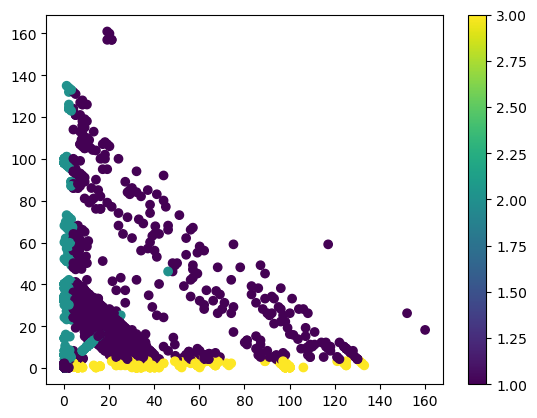

In [284]:
plt.scatter(oldphase1, oldphase2, c=1 + phased1.astype(int) + 2 * phased2.astype(int))
plt.colorbar()

In [413]:
for extension in range(50, 1001, 50):
    startandend = np.array([start0, end0])
    startandend[0] -= extension
    startandend[1] += extension
    start32 = startandend[0] // 32 + 1
    end32 = startandend[1] // 32 + 1
    start = (start32 - 1) * 32 + 1
    end = end32 * 32

    tempIE = distinctHapsIE.iloc[:, start-1:end]
    tempB = distinctHapsB.iloc[:, start32-1:end32]
    temp = rhb_t.iloc[:, start32-1:end32]
    temp2 = pd.DataFrame(np.zeros((temp.shape[0], tempIE.shape[1])))

    cc = np.array([0.001] * 31 + [0.999])    
    for i in range(temp.shape[1]):
        start_col = (i * 32)
        end_col = (i + 1) * 32
        for r, j in enumerate(temp.iloc[:, i].tolist()):
            idx = tempB.iloc[:, i].index[tempB.iloc[:, i] == j]
            if len(idx) != 0: # **Y**
                temp2.iloc[r, start_col:end_col] = tempIE.iloc[idx[0], start_col:end_col] 
        cc2 = np.where(pd.isna(temp.iloc[:, i]))[0]
        if len(cc2) > 0:
            cc3 = np.tile(cc, (len(cc2), 1))
            temp2.iloc[cc2, start_col:end_col] = cc3
        needed = np.where(temp2.iloc[:, end_col-1] == 0)[0]
        if len(needed) > 0:
            temp2.iloc[needed, start_col:end_col] = translate(temp.iloc[needed, i])
    temp2 = temp2.iloc[:, (startandend[0] - start - 1):(startandend[1] - start)]

    alleles = np.empty(len(temp2), dtype = object)
    alleles[::2] = allele1
    alleles[1::2] = allele2
    nameset = np.unique(alleles[alleles != 'None'])
    
    predmat = np.zeros((len(nameset), temp2.shape[1]))
    for i, name in enumerate(nameset):
        predmat[i, :] = np.mean(temp2.iloc[alleles == name, :], axis=0)
    
    predmatallele1 = np.full((len(reftypes1), temp2.shape[1]), np.nan)
    predmatallele2 = np.full((len(reftypes1), temp2.shape[1]), np.nan)
    
    for i in range(len(reftypes1)):
        if reftypes1[i] in nameset: 
            predmatallele1[i, :] = predmat[np.where(nameset == reftypes1[i])[0][0], :]
        if reftypes2[i] in nameset: 
            predmatallele2[i, :] = predmat[np.where(nameset == reftypes2[i])[0][0], :]
    # Well, strongly suspect this bit.. 
    # Why we're taking information again from temp2? isn't that we should reconstruct newhaps2 by extending 50 SNPs?
    
    obsmatallele1 = temp2.iloc[::2, :].reset_index(drop = True) # previously hrcfirstallele
    obsmatallele2 = temp2.iloc[1::2, :].reset_index(drop = True)
    
    dist11 = np.sum(np.abs(obsmatallele1 - predmatallele1) > 0.9, axis=1)
    dist12 = np.sum(np.abs(obsmatallele1 - predmatallele2) > 0.9, axis=1)
    dist21 = np.sum(np.abs(obsmatallele2 - predmatallele1) > 0.9, axis=1)
    dist22 = np.sum(np.abs(obsmatallele2 - predmatallele2) > 0.9, axis=1)

    phase1b = dist11 + dist22
    phase2b = dist12 + dist21
    
    d11 = dist11
    d21 = dist21
    d12 = dist12
    d22 = dist22
    
    phased1b = (
        (~np.isnan(phase1b) & ~np.isnan(phase2b) & (phase1b < phase2b)) |
        ((reftypes1 != 'nan') & (reftypes2 != 'nan') & (reftypes1 == reftypes2)) |
        (np.isnan(d21) & ~np.isnan(d12) & (d12 - d22 > 2)) |
        (np.isnan(d12) & ~np.isnan(d21) & (d21 - d11 > 2))
    )

    phased2b = (
        (~np.isnan(phase1b) & ~np.isnan(phase2b) & (phase1b > phase2b)) |
        (np.isnan(d21) & ~np.isnan(d12) & (d22 - d12 > 2)) |
        (np.isnan(d12) & ~np.isnan(d21) & (d11 - d21 > 2))
    )
    
    update = ~phased1 & ~phased2
    phased1[update] = phased1b[update]
    phased2[update] = phased2b[update]

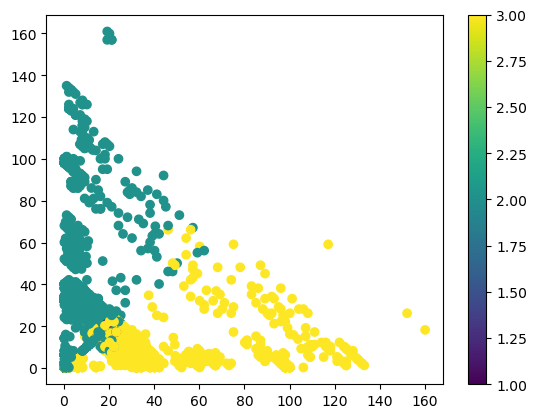

In [405]:
plt.scatter(oldphase1, oldphase2, c=1 + phased1.astype(int) + 2 * phased2.astype(int))
plt.colorbar()

In [ ]:
unphased_samples = (phased1 != True) & (phased2 != True)

In [6]:
hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv')
hla

,SampleID,Locus,One field1,Two field1,One field2,Two field2
